# Object detection and masking from prompts with GroundedSAM (GroundingDINO + SAM) and OpenVINO

In this notebook, we provide the OpenVINO™ optimization for combination of GroundingDINO + SAM = [GroundedSAM](https://github.com/IDEA-Research/Grounded-Segment-Anything) on Intel® platforms. GroundedSAM aims to detect and segment anything with text inputs. GroundingDINO is a language-guided query selection module to enhance object detection using input text. It selects relevant features from image and text inputs and returns predicted box with detections.

The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. We use box predictions from GroundingDINO to mask original image.

More details about model can be found in [paper](https://arxiv.org/abs/2401.14159) and official [repository](https://github.com/IDEA-Research/Grounded-Segment-Anything).

![image](https://github.com/openvinotoolkit/openvino_notebooks/assets/5703039/3c19063a-c60a-4d5d-b534-e1305a854180)

#### Table of contents:
- [Clone repository and install requirements](#Clone-repository-and-install-requirements)
- [Download checkpoints and load PyTorch model](#Download-checkpoints-and-load-PyTorch-model)
- [Convert GroundingDINO to OpenVINO IR format](#Convert-GroundingDINO-to-OpenVINO-IR-format)
- [Run OpenVINO optimized GroundingDINO](#Run-OpenVINO-optimized-GroundingDINO)
- [Convert SAM to OpenVINO IR](#Convert-SAM-to-OpenVINO-IR)
- [Combine GroundingDINO + SAM (GroundedSAM)](#Combine-GroundingDINO-+-SAM-(GroundedSAM))
- [Interactive GroundedSAM](#Interactive-GroundedSAM)
- [Cleanup](#Cleanup)


### Clone repositories and install requirements
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q timm --extra-index-url https://download.pytorch.org/whl/cpu # is needed for torch
%pip install -q "openvino-nightly>=2024.1.0.dev20240219" opencv-python supervision transformers yapf pycocotools addict gradio


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


To limit cpu time and ram consumption by default we use EfficientSAM for segmentation, but if you wish more accurate segmentation you can select vanilla `SAM`.

In [2]:
import ipywidgets

sam_type_widget = ipywidgets.Dropdown(
    options=['EfficientSAM', 'SAM'],
    value='EfficientSAM',
    description='Segment Anything type:',
)
sam_type_widget

Dropdown(description='Segment Anything type:', options=('EfficientSAM', 'SAM'), value='EfficientSAM')

In [3]:
use_efficient_sam = sam_type_widget.value == 'EfficientSAM'

In [4]:
from pathlib import Path
import sys
import os

repo_dir = Path("Grounded-Segment-Anything")
ground_dino_dir = Path('GroundingDINO')
efficient_sam_dir = Path('EfficientSAM')

# we use grounding dino from a fork which contains modifications that allow conversion to OpenVINO IR format
if not ground_dino_dir.exists():
    !git clone https://github.com/wenyi5608/GroundingDINO/
if use_efficient_sam and not efficient_sam_dir.exists():
    !git clone https://github.com/yformer/EfficientSAM
if not use_efficient_sam and not repo_dir.exists():
    !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

# append to sys.path so that modules from the repo could be imported
sys.path.append(str(ground_dino_dir))
sys.path.append(str('EfficientSAM' if use_efficient_sam else repo_dir / 'segment_anything'))

In [5]:
import torch
import numpy as np
import supervision as sv
import openvino as ov
from PIL import Image, ImageDraw, ImageFont
from typing import Union, List

core = ov.Core()

### Download checkpoints and load PyTorch models
[back to top ⬆️](#Table-of-contents:)

In [6]:
IRS_PATH = Path('openvino_irs')
CKPT_BASE_PATH = Path('checkpoints')
os.makedirs(IRS_PATH, exist_ok=True)
os.makedirs(CKPT_BASE_PATH, exist_ok=True)

PT_DEVICE = 'cpu'
ov_dino_name = 'openvino_grounding_dino'
ov_sam_name = 'openvino_segment_anything'

ground_dino_img_size = (1024, 1280)

# GroundingDINO config and checkpoint 
GROUNDING_DINO_CONFIG_PATH = f"{repo_dir}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = CKPT_BASE_PATH / "groundingdino_swint_ogc.pth"
# Segment-Anything checkpoint
SAM_CHECKPOINT_PATH = CKPT_BASE_PATH / "sam_vit_h_4b8939.pth"

In [7]:
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file

download_file("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth", directory=CKPT_BASE_PATH)
if not use_efficient_sam:
    download_file("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth", directory=CKPT_BASE_PATH)

'checkpoints/groundingdino_swint_ogc.pth' already exists.


GroundingDINO imports

In [8]:
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util import get_tokenlizer

/home/epavel/devel/openvino_notebooks/notebooks/288-grounded-segment-anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [9]:
def load_pt_grounding_dino(model_config_path, model_checkpoint_path, cpu_only=True):
    args = SLConfig.fromfile(model_config_path)
    
    # modified config
    args.device = PT_DEVICE
    args.use_checkpoint = False
    args.use_transformer_ckpt = False
    
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    _ = model.eval()
    return model

In [10]:
def load_pt_efficient_sam(checkpoint: str):
    from efficient_sam.efficient_sam import build_efficient_sam
    return build_efficient_sam(encoder_patch_embed_dim=192, encoder_num_heads=3, checkpoint=checkpoint).eval()

In [11]:
# load extension to skip manually specific cells when EfficientSAM is used
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/skip_kernel_extension.py',
    filename='skip_kernel_extension.py'
)

%load_ext skip_kernel_extension

In [12]:
# Load GroundingDINO inference model
pt_grounding_dino_model = load_pt_grounding_dino(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)

if use_efficient_sam:
    # Load SAM Model and SAM Predictor
    efficient_sam_model = load_pt_efficient_sam(efficient_sam_dir / "weights/efficient_sam_vitt.pt")
else:
    from segment_anything import build_sam, SamPredictor
    # Load SAM Model and SAM Predictor
    sam = build_sam(checkpoint=SAM_CHECKPOINT_PATH).to(PT_DEVICE)
    sam_predictor = SamPredictor(sam)

/home/epavel/opt/envs/py310-grounding-sam-test/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


### Convert GroundingDINO to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

In order to convert valid example inputs are necessary

In [13]:
ov_dino_path = IRS_PATH / f'{ov_dino_name}.xml'

if not ov_dino_path.exists():
    tokenized = pt_grounding_dino_model.tokenizer(["the running dog ."], return_tensors="pt")
    input_ids = tokenized['input_ids']
    token_type_ids = tokenized['token_type_ids']
    attention_mask = tokenized['attention_mask']
    position_ids = torch.arange(input_ids.shape[1]).reshape(1, -1)
    text_token_mask = torch.randint(0, 2, (1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.bool)
    img = torch.randn(1, 3, *ground_dino_img_size)
    
    dummpy_inputs = img, input_ids, attention_mask, position_ids, token_type_ids, text_token_mask

    pt_grounding_dino_model.eval()
    for par in pt_grounding_dino_model.parameters():
        par.requires_grad = False
    traced_model = torch.jit.trace(pt_grounding_dino_model, example_inputs=dummpy_inputs, strict=False, check_trace=False)

    ov_dino_model = ov.convert_model(traced_model, example_input=dummpy_inputs)
    ov.save_model(ov_dino_model, ov_dino_path)
else:
    ov_dino_model = core.read_model(ov_dino_path)

### Run OpenVINO optimized GroundingDINO
[back to top ⬆️](#Table-of-contents:)

In [14]:
device_widget = ipywidgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
)
device_widget

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [15]:
def build_compiled_model(model_config_path, ov_dino_model, device):   
    model = core.compile_model(ov_dino_model, device.upper())
    args = SLConfig.fromfile(model_config_path)
    model.tokenizer = get_tokenlizer.get_tokenlizer(args.text_encoder_type)
    model.max_text_len = args.max_text_len
    return model

device = device_widget.value
ov_compiled_grounded_dino = build_compiled_model(GROUNDING_DINO_CONFIG_PATH, ov_dino_model, device)

final text_encoder_type: bert-base-uncased


In [16]:
# todo: provide explanation
def get_ov_grounding_output(model: ov.CompiledModel, image, caption: Union[str, List[str]], box_threshold, 
                            text_threshold=None, 
                            with_logits=True):
    from groundingdino.util.utils import get_phrases_from_posmap
    from groundingdino.models.GroundingDINO.bertwarper import generate_masks_with_special_tokens_and_transfer_map

    if isinstance(caption, list):
        caption = '. '.join(caption)
    
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
        
    captions = [caption]
    # encoder texts
    tokenized = model.tokenizer(captions, padding="longest", return_tensors="pt")
    specical_tokens = model.tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]", ".", "?"])
    
    (
        text_self_attention_masks,
        position_ids,
        cate_to_token_mask_list,
    ) = generate_masks_with_special_tokens_and_transfer_map(
        tokenized, specical_tokens, model.tokenizer)

    if text_self_attention_masks.shape[1] > model.max_text_len:
        text_self_attention_masks = text_self_attention_masks[
            :, : model.max_text_len, : model.max_text_len]
        
        position_ids = position_ids[:, : model.max_text_len]
        tokenized["input_ids"] = tokenized["input_ids"][:, : model.max_text_len]
        tokenized["attention_mask"] = tokenized["attention_mask"][:, : model.max_text_len]
        tokenized["token_type_ids"] = tokenized["token_type_ids"][:, : model.max_text_len]

    inputs = {}
    
    # TODO: write explanation why it's needed
    from torchvision.transforms.functional import resize, InterpolationMode
    pre_image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
    image_ = resize(pre_image, ground_dino_img_size, interpolation=InterpolationMode.BICUBIC)
    input_img = np.expand_dims(image_, 0)

    inputs["samples"] = input_img
    inputs["attention_mask.1"] = tokenized["attention_mask"]
    inputs["text_self_attention_masks"] = text_self_attention_masks 
    inputs["input_ids"] = tokenized["input_ids"]
    inputs["position_ids"] = position_ids
    inputs["token_type_ids"] = tokenized["token_type_ids"]

    # ov inference
    request = model.create_infer_request()
    request.start_async(inputs, share_inputs=False)
    request.wait()
    outputs = {}
    outputs["logits"] = request.get_tensor("pred_logits").data
    outputs["boxes"] = request.get_tensor("pred_boxes").data
       
    def sig(x):
        return 1 / (1 + np.exp(-x))
    
    prediction_logits_ = np.squeeze(outputs["logits"], 0)
    prediction_logits_ = sig(prediction_logits_)
    prediction_boxes_ = np.squeeze(outputs["boxes"], 0)
    logits = torch.from_numpy(prediction_logits_)
    boxes = torch.from_numpy(prediction_boxes_)
    
    # filter output
    logits_filt = logits.cpu().clone()
    boxes_filt = boxes.cpu().clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases, logits_filt.max(dim=1)[0]

In [17]:
SOURCE_IMAGE_PATH = f"{repo_dir}/assets/demo7.jpg"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

In [18]:
def transform_image(image_pil):
    import groundingdino.datasets.transforms as T
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image

pil_image = Image.open(SOURCE_IMAGE_PATH)
image = np.array(pil_image)
transformed_image = np.array(transform_image(pil_image))

In [19]:
classes_prompt = ["Horse", "Cloud"]

In [20]:
boxes_filt, pred_phrases, logits_filt = get_ov_grounding_output(
    ov_compiled_grounded_dino,
    transformed_image,
    classes_prompt,
    BOX_THRESHOLD, TEXT_THRESHOLD
)

In [21]:
from groundingdino.util.inference import Model

source_w, source_h = pil_image.size
detections = Model.post_process_result(
    source_h=source_h,
    source_w=source_w,
    boxes=boxes_filt,
    logits=logits_filt)

class_id = Model.phrases2classes(phrases=pred_phrases, classes=list(map(str.lower, classes_prompt)))
detections.class_id = class_id

Draw the annotations

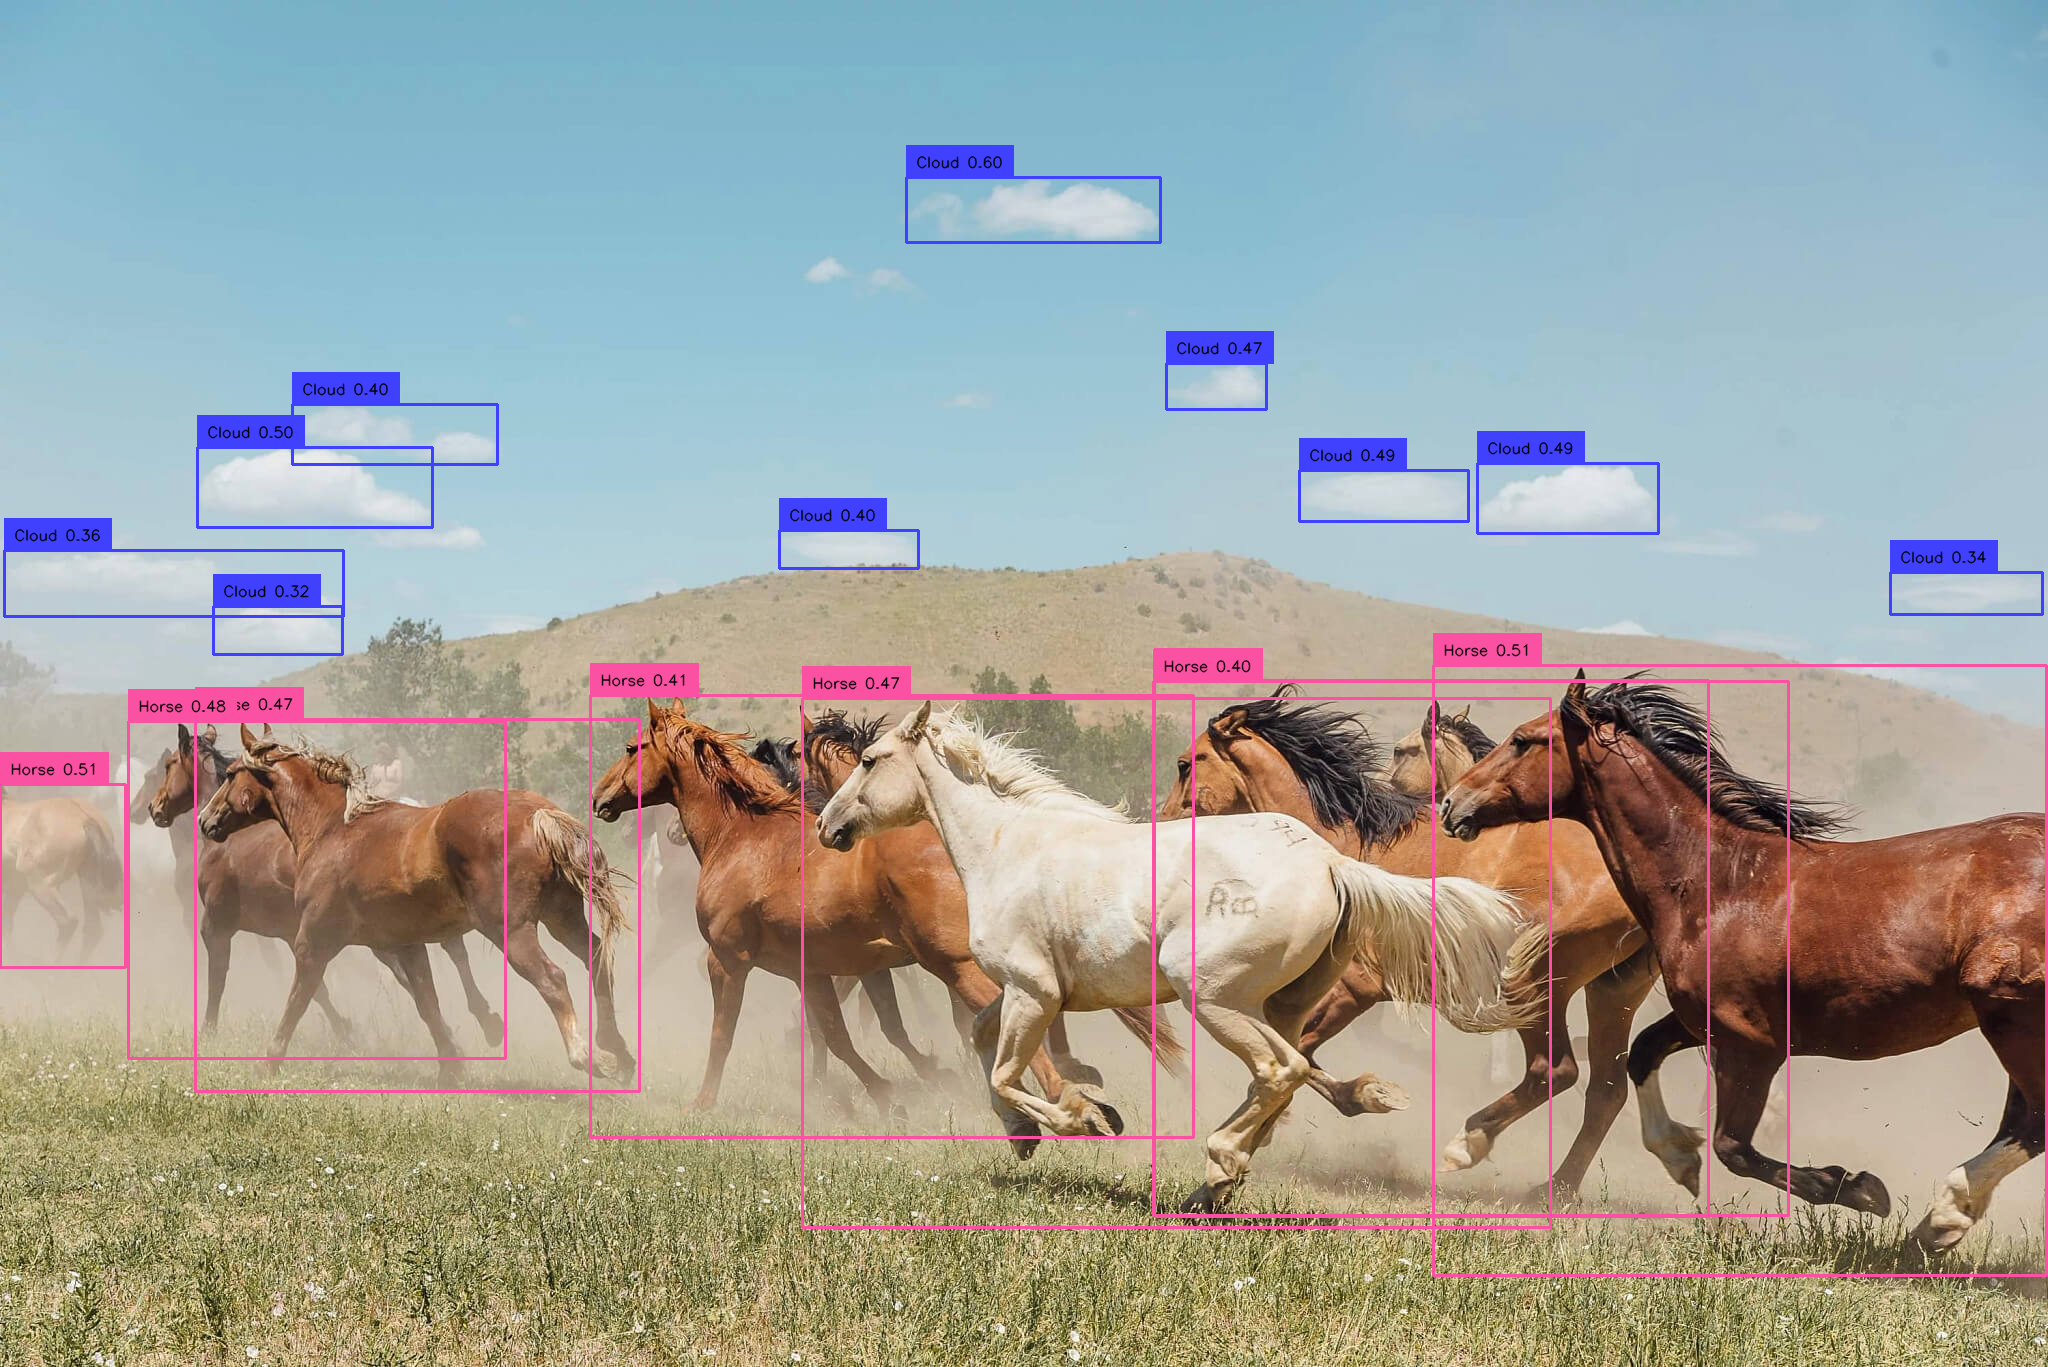

In [22]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{classes_prompt[class_id] if class_id is not None else 'None'} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

Image.fromarray(annotated_frame)

### Convert SAM to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

And now let's feed those detection to SAM model. Firstly we need to convert SAM to OpenVINO format.

Image pre/post processing utils

In [23]:
class SamMaskFromBoxes(torch.nn.Module):
    def __init__(
        self,
        sam_predictor,
    ) -> None:
        super().__init__()
        self.model = sam_predictor

    @torch.no_grad()
    def forward(
        self,
        input_image: torch.Tensor,
        transformed_boxes: torch.Tensor,
        multimask_output: bool = False,
        hq_token_only: bool = False,
    ):
        pre_processed_image = self.model.model.preprocess(input_image)
        image_embeddings, interm_features = self.model.model.image_encoder(pre_processed_image)
        
        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.model.prompt_encoder(
            points=None,
            boxes=transformed_boxes,
            masks=None,
        )

        # Predict masks
        low_res_masks, iou_predictions = self.model.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output,
            hq_token_only=hq_token_only,
            interm_embeddings=interm_features,
        )

        return low_res_masks, iou_predictions

export SAM to IR

In [24]:
%%skip $use_efficient_sam

exportable = SamMaskFromBoxes(sam_predictor)

exportable.model.model.eval()
for par in exportable.model.model.parameters():
    par.requires_grad = False

example_image = np.array(Image.open(SOURCE_IMAGE_PATH).convert("RGB"))
transfromed_example_image = exportable.model.transform.apply_image(example_image)
input_image_torch = torch.as_tensor(transfromed_example_image, device=PT_DEVICE)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

dummy_transformed_boxes = torch.rand(1, 4, dtype=torch.float32) * 200

In [25]:
%%skip $use_efficient_sam

ov_sam_path = IRS_PATH / f'{ov_sam_name}.xml'
if not ov_sam_path.exists():   
    traced = torch.jit.trace(exportable, example_inputs=(input_image_torch, dummy_transformed_boxes))
    ov_sam = ov.convert_model(traced, example_input=(input_image_torch, dummy_transformed_boxes))
    ov.save_model(ov_sam, ov_sam_path)
else:
    ov_sam = core.read_model(ov_sam_path)

compiled_vanilla_sam = core.compile_model(ov_sam, device_name=device)

In [26]:
%%skip not $use_efficient_sam

ov_efficient_sam_name = 'openvino_efficient_sam'
ov_efficient_sam_path = IRS_PATH / f'{ov_efficient_sam_name}.xml'

if not ov_efficient_sam_path.exists():
    random_input_image = np.random.rand(1, 3, *image.shape[:2])
    bounding_box = np.array([900, 100, 1000, 200]).reshape([1, 1, 2, 2])
    bbox_labels = np.array([2, 3]).reshape([1, 1, 2])
    efficient_sam_dummy_input = tuple(torch.from_numpy(x) for x in (input_image, bounding_box, bbox_labels))

    ov_efficient_sam = ov.convert_model(efficient_sam_model, example_input=efficient_sam_dummy_input)
    ov.save_model(ov_efficient_sam, ov_efficient_sam_path)
else:
    ov_efficient_sam = core.read_model(ov_efficient_sam_path)

compiled_efficient_sam = core.compile_model(ov_efficient_sam, 'CPU')

### Combine GroundingDINO + SAM (GroundedSAM)
[back to top ⬆️](#Table-of-contents:)

In [27]:
%%skip $use_efficient_sam

def predict_sam_masks(predictor, image, transformed_boxes):
    transfromed_example_image = exportable.model.transform.apply_image(image)
    input_image_torch = torch.as_tensor(transfromed_example_image, device=PT_DEVICE)
    input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    original_size = tuple(image.shape[:2])
    input_size = tuple(input_image_torch.shape[-2:])

    low_res_masks = predictor((input_image_torch, transformed_boxes))[0]
    
    # Upscale the masks to the original image resolution
    masks = exportable.model.model.postprocess_masks(torch.from_numpy(low_res_masks), input_size, original_size)
    masks = masks > exportable.model.model.mask_threshold
    return masks

In [28]:
def transform_boxes(sam_predictor, boxes, size):
    H, W = size[0], size[1]
    for i in range(boxes.size(0)):
        boxes[i] = boxes[i] * torch.Tensor([W, H, W, H])
        boxes[i][:2] -= boxes[i][2:] / 2
        boxes[i][2:] += boxes[i][:2]

    return sam_predictor.transform.apply_boxes_torch(boxes, size).to(PT_DEVICE)

In [29]:
def predict_efficient_sam_mask(predictor, image, bbox):
    input_size = 1024
    w, h = image.size[:2]
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))
    
    np_image = np.array(image, dtype=np.float32) / 255.0
    img_tensor = np.transpose(np_image, (2, 0, 1))[None, ...]

    scaled_points = bbox * scale

    bounding_box = scaled_points.reshape([1, 1, 2, 2])
    bbox_labels = np.reshape(np.array([2, 3]), [1, 1, 2])
    esam_input = (img_tensor, bounding_box, bbox_labels)

    res = predictor(esam_input)

    predicted_logits, predicted_iou = res[0], res[1]

    all_masks = torch.ge(torch.sigmoid(torch.from_numpy(predicted_logits[0, 0, :, :, :])), 0.5).numpy()
    predicted_iou = predicted_iou[0, 0, ...]

    max_predicted_iou = -1
    selected_mask_using_predicted_iou = None
    for m in range(all_masks.shape[0]):
        curr_predicted_iou = predicted_iou[m]
        if (
            curr_predicted_iou > max_predicted_iou
            or selected_mask_using_predicted_iou is None
        ):
            max_predicted_iou = curr_predicted_iou
            selected_mask_using_predicted_iou = all_masks[m]
    return selected_mask_using_predicted_iou

def predict_efficient_sam_masks(compiled_efficient_sam, pil_image, transformed_boxes):
    masks = []
    for bbox in transformed_boxes:
        mask = predict_efficient_sam_mask(compiled_efficient_sam, pil_image, bbox)
        mask = Image.fromarray(mask).resize(pil_image.size)
        masks.append(np.array(mask))
    masks = torch.from_numpy(np.array(masks))
    return masks

In [30]:
if use_efficient_sam:
    masks = predict_efficient_sam_masks(compiled_efficient_sam, pil_image, detections.xyxy)
    detections.mask = masks.numpy()
else:
    transformed_boxes = transform_boxes(sam_predictor, boxes_filt, image.shape[:2])
    masks = predict_sam_masks(compiled_vanilla_sam, image, transformed_boxes)
    detections.mask = masks[:, 0].numpy()

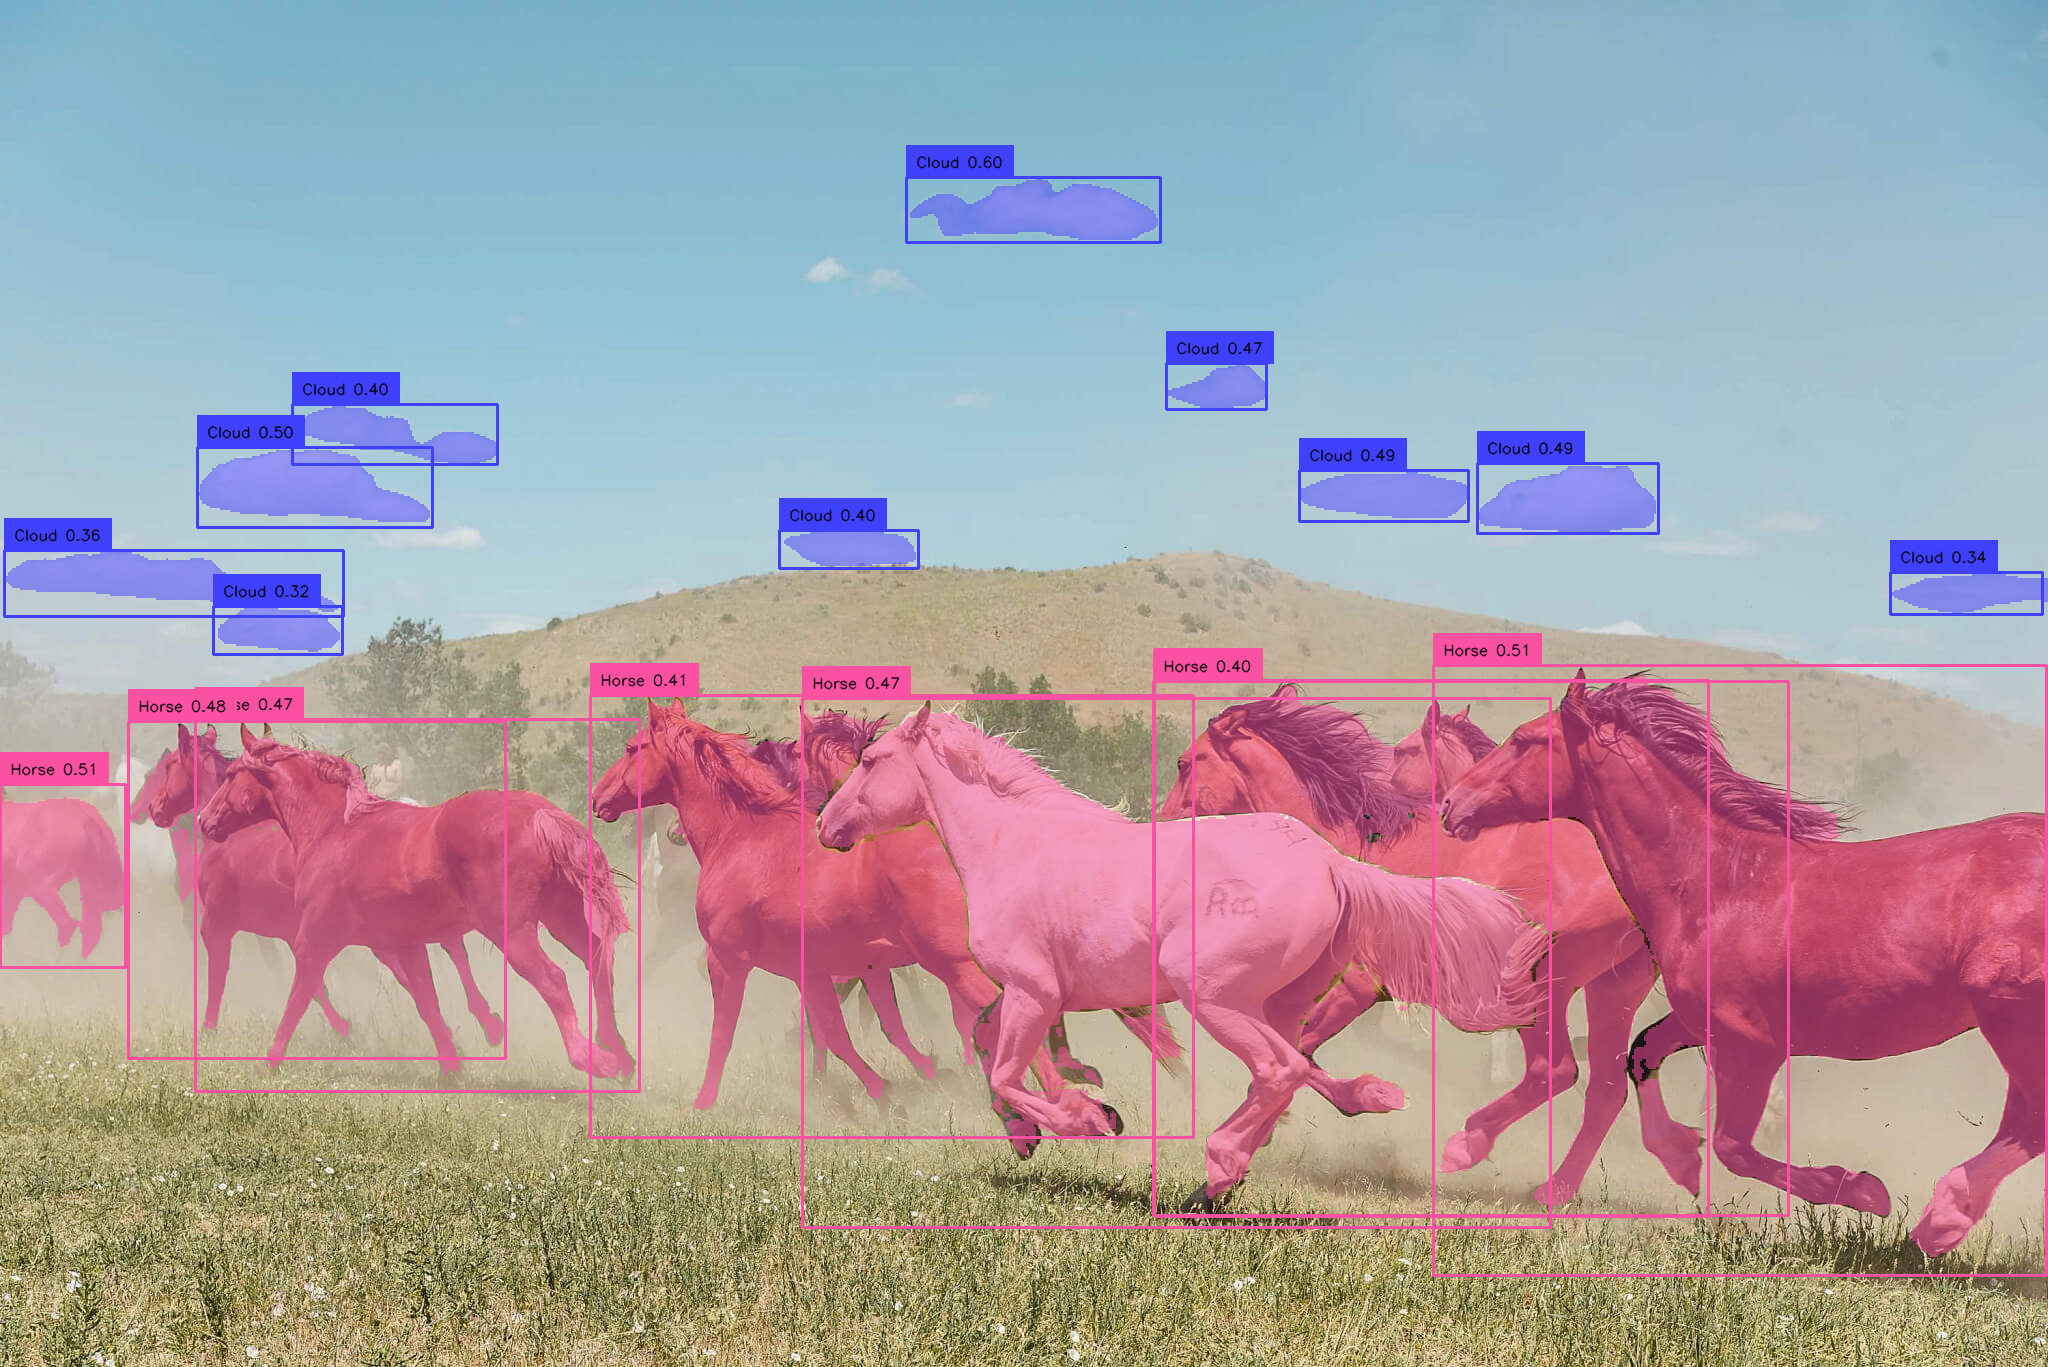

In [31]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

Image.fromarray(annotated_image)

### Interactive GroundedSAM
[back to top ⬆️](#Table-of-contents:)

Now, you can try apply grounding sam on own images using interactive demo. The code below provides helper functions used in demonstration.

In [32]:
def draw_mask(mask, draw, random_color=False):
    import random
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

def draw_box(box, draw, label):
    # random color
    color = tuple(np.random.randint(0, 255, size=3).tolist())

    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=4)

    if label:
        font = ImageFont.load_default(18)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font, anchor='ld')
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], box[0] + w, box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white", anchor='ld', font=font)

In [33]:
""""
run_grounding_sam is called every time "Submit" button is clicked
"""
def run_grounding_sam(input_image, task_type, text_prompt, box_threshold, text_threshold): 
    image = input_image
    image_pil = Image.fromarray(image)
    size = image.shape[1], image.shape[0]  # size is WH image.shape HWC
    
    transformed_image = transform_image(image_pil)
    
    boxes_filt, scores, pred_phrases = get_ov_grounding_output(
        ov_compiled_grounded_dino, 
        transformed_image, 
        text_prompt, 
        box_threshold, 
        text_threshold
    )

    # process boxes
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()

    if task_type == 'seg':
        if use_efficient_sam:
            masks = predict_efficient_sam_masks(compiled_efficient_sam, image_pil, boxes_filt.numpy())
        else:
            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(PT_DEVICE)
            masks = predict_sam_masks(compiled_vanilla_sam, image, transformed_boxes)[:, 0]

        mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
        mask_draw = ImageDraw.Draw(mask_image)
        for mask in masks:
            draw_mask(mask.cpu().numpy(), mask_draw, random_color=True)

        image_draw = ImageDraw.Draw(image_pil)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)

        image_pil = image_pil.convert('RGBA')
        image_pil.alpha_composite(mask_image)

        return [image_pil, mask_image]
    if task_type == 'det':
        image_draw = ImageDraw.Draw(image_pil)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)
        return [image_pil]
    else:
        gr.Warning(f"task_type:{task_type} error!")

You can run interactive app with your own image and text prompts. To define prompt specify comma (or conjunction) separated names of objects you wish to segment. For demonstration, this demo already has two predefined examples. If many object are crowded and overlapping please increase threshold values in `Advanced options`.

In [34]:
import gradio as gr

with gr.Accordion("Advanced options", open=False) as advanced:
    box_threshold = gr.Slider(label="Box Threshold", minimum=0.0, maximum=1.0, value=0.3, step=0.05)
    text_threshold = gr.Slider(label="Text Threshold", minimum=0.0, maximum=1.0, value=0.25, step=0.05)

demo = gr.Interface(
    run_grounding_sam,
    [
        gr.Image(),
        gr.Dropdown(["det", "seg"], value="seg", label="task_type"),
        gr.Textbox(value='bears', label="Text Prompt"),
    ],
    additional_inputs=[
        box_threshold,
        text_threshold,
    ],
    outputs=gr.Gallery(preview=True, object_fit="scale-down"),
    examples=[[f"{repo_dir}/assets/demo1.jpg", "seg", 'bear'], [f"{repo_dir}/assets/demo7.jpg", "seg", 'horses and clouds']],
    additional_inputs_accordion=advanced,
)

try:
    demo.launch(server_name='0.0.0.0', debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://0.0.0.0:7861

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Cleanup
[back to top ⬆️](#Table-of-contents:)

In [ ]:
# import shutil
# shutil.rmtree(CKPT_BASE_PATH)
# shutil.rmtree(IRS_PATH)